# Table of Content:

### 0. Objectives

### 1. Loading Data

### 2. Data Cleaning & Preprocessing

### 3. Descriptive Analysis (Patterns)

### 4. Feature Engineering for Prediction

### 5. Baseline Forecasting Models

### 6. ML Models (Tree-based + Neural Nets)

### 7. Wrap-up & Presentation


## 0. Objectives

Descriptive:

- Identify daily, weekly, and seasonal patterns of PM2.5/PM10.

- Compare air quality across weekdays vs weekends and daytime vs nighttime.

- Visualize pollution cycles that align with traffic, heating, or special events (e.g., fireworks, holidays).

Predictive:

- Build models to predict next-day PM2.5 levels.

- Compare classical and machine learning approaches:

- Baseline: ARIMA or Holt-Winters

- ML: Random Forest, XGBoost

- Deep Learning: LSTM / GRU


### Setup:


In [78]:
# --- Core data stack ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Stats & time-series helpers ---
from scipy import stats                     # t-tests, basic stats
from statsmodels.tsa.seasonal import STL, seasonal_decompose  # trend/seasonality
import matplotlib.dates as mdates

# --- Quality of life ---
from tqdm import tqdm  # progress bars for loops (e.g., many days/years)
from zoneinfo import ZoneInfo

# --- ML ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin


## Define PurpleAir DF features:


### `humidity`

- **What:** Relative humidity.
- **Units:** % (0–100).
- **Notes:** Can be biased on some devices; consider smoothing and bounds checks.

---

### `temperature`

- **What:** Ambient temperature reported by the onboard environmental sensor.
- **Units:** °F (PurpleAir commonly reports Fahrenheit via API).
- **Notes:** Convert to °C if needed: `(F − 32) × 5/9`. Can read slightly high in sun or near walls.

---

### `pressure`

- **What:** Barometric pressure at the sensor.
- **Units:** hPa (hectopascals).
- **Notes:** Varies with elevation and weather; Bishkek (\~760 m) typically shows \~920–940 hPa.

---

### `voc`

- **What:** Volatile Organic Compounds signal or index (only on models with a VOC sensor).
- **Units:** Device/firmware dependent (often an index, sometimes absent).
- **Notes:** Many PurpleAir units do not report VOC → expect `NaN` frequently.

---

### `analog_input`

- **What:** Raw analog input channel for external integrations.
- **Units:** Unitless (normalized 0–1) or device-specific voltage proxy.
- **Notes:** Often unused (constant near `0.02–0.05` or `0.0`). Treat as optional/diagnostic.

---

### `pm2.5_alt`

- **What:** Alternate PM2.5 mass concentration derived from particle counts (the Lance Wallace method).
- **Units:** µg/m³.
- **Formula:**

  ```text
  pm2.5_alt = C * (0.00030418*N1 + 0.0018512*N2 + 0.02069706*N3)
  ```

  where **C** is a constant “CF factor” (commonly 3.0; some use 3.4) and **N1–N3** are small-particle count bins from the sensor.

- **Notes:** Useful when comparing against `cf_1` and `atm` outputs; sensitive to count noise.

---

### `deciviews`

- **What:** Logarithmic haze metric (higher = hazier).
- **Units:** deciview (dv).
- **Notes:** Derived from estimated light extinction; intended for visibility/haze interpretation rather than compliance reporting.

---

### `visual_range`

- **What:** Estimated visibility distance derived from aerosol extinction.
- **Units:** Typically km.
- **Notes:** Lower values indicate poorer visibility; derived (not directly measured).

---

### `0.3_um_count`, `0.5_um_count`, `1.0_um_count`, `2.5_um_count`, `5.0_um_count`, `10.0_um_count`

- **What:** Particle number counts in size bins ≥0.3 µm, ≥0.5 µm, …, ≥10 µm.
- **Units:** Particles per 0.1 L (Plantower convention) or device-specific count units.
- **Notes:** Extremely wide dynamic range—plot on **log scale**. Great for research/QC and diagnosing sensor issues.

---

### `pm1.0_cf_1`, `pm2.5_cf_1`, `pm10.0_cf_1`

- **What:** Mass concentrations computed by the sensor’s **CF=1** factory algorithm.
- **Units:** µg/m³.
- **Use:** Good for method comparison and diagnostics; may not best match outdoor regulatory references.

---

### `pm1.0_atm`, `pm2.5_atm`, `pm10.0_atm`

- **What:** Mass concentrations with the sensor’s **“atmospheric”** correction.
- **Units:** µg/m³.
- **Use (recommended):** For outdoor reporting and AQI conversion, use `*_atm` (especially `pm2.5_atm`).
- **Notes:** Often aligns better with ambient aerosol than `cf_1`.


In [79]:
# Loading PurpleAir Data Frames
df_purpleAir_44919 = pd.read_csv('44919 2016-08-26 2025-08-26 60-Minute Average.csv')
df_purpleAir_92387 = pd.read_csv('92387 2016-08-26 2025-08-26 60-Minute Average.csv')
df_purpleAir_217883 = pd.read_csv('217883 2016-08-26 2025-08-26 60-Minute Average.csv')

df_purpleAir_44919.head()

,time_stamp,humidity,temperature,pressure,voc,analog_input,pm2.5_alt|pm2.5_alt = C * (0.00030418*N1 0.0018512*N2 0.02069706*N3),deciviews,visual_range,0.3_um_count,...,1.0_um_count,2.5_um_count,5.0_um_count,10.0_um_count,pm1.0_cf_1,pm1.0_atm,pm2.5_atm,pm2.5_cf_1,pm10.0_atm,pm10.0_cf_1
0,2025-01-15T07:00:00+06:00,16,72,935.98,NaN,0.04,10.6,16.9,71.6,2470.2,...,112.26,17.30,4.834,2.622,12.0,12.0,18.4,18.4,22.2,22.2
1,2025-01-15T08:00:00+06:00,18,56,936.21,NaN,0.04,15.7,20.3,51.4,3657.7,...,164.92,26.63,6.509,3.412,20.3,19.2,29.3,30.9,36.0,36.5
2,2025-01-15T09:00:00+06:00,22,46,936.45,NaN,0.05,16.4,20.0,52.8,3550.6,...,188.31,33.56,7.445,3.638,20.6,20.3,32.9,33.9,40.7,40.7
3,2025-01-15T10:00:00+06:00,20,50,936.39,NaN,0.05,22.9,22.4,41.6,4652.3,...,275.75,48.06,10.694,5.239,26.8,23.9,39.5,46.1,51.4,55.6
4,2025-01-15T11:00:00+06:00,17,53,936.27,NaN,0.05,14.2,19.3,56.4,3283.3,...,162.32,27.93,5.728,2.579,15.7,15.5,26.4,27.0,31.8,31.9


In [80]:
df_purpleAir_44919.describe()

,humidity,temperature,pressure,voc,analog_input,pm2.5_alt|pm2.5_alt = C * (0.00030418*N1 0.0018512*N2 0.02069706*N3),deciviews,visual_range,0.3_um_count,0.5_um_count,1.0_um_count,2.5_um_count,5.0_um_count,10.0_um_count,pm1.0_cf_1,pm1.0_atm,pm2.5_atm,pm2.5_cf_1,pm10.0_atm,pm10.0_cf_1
count,5333.000000,5333.000000,5333.000000,0.0,5332.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000
mean,30.636790,70.917495,929.868637,NaN,0.043638,27.151416,19.671873,68.558241,5135.471273,1444.568611,337.455586,53.441378,13.772453,6.286568,31.905625,24.289162,41.189068,55.112676,52.084699,68.182205
std,12.183037,19.654373,6.650782,NaN,0.004811,42.031110,7.621115,39.697254,6569.250133,1944.365056,584.650982,96.192155,25.958029,11.662299,67.878155,44.519029,67.760454,103.685645,83.295932,127.279819
min,7.000000,21.000000,915.200000,NaN,0.040000,1.600000,4.800000,3.500000,344.600000,96.200000,16.560000,2.050000,0.564000,0.191000,0.900000,0.900000,1.900000,1.900000,2.300000,2.300000
25%,21.000000,53.000000,924.590000,NaN,0.040000,7.200000,14.000000,36.500000,1707.200000,453.800000,74.170000,10.970000,3.246000,1.480000,8.000000,8.000000,12.000000,12.000000,15.200000,15.200000
50%,28.000000,76.000000,929.510000,NaN,0.040000,11.700000,17.700000,66.300000,2710.800000,726.100000,125.220000,20.140000,5.574000,2.538000,13.600000,13.400000,20.300000,20.500000,25.300000,25.400000
75%,39.000000,87.000000,934.590000,NaN,0.050000,26.500000,23.700000,95.800000,5381.000000,1502.100000,320.970000,50.860000,11.934000,5.557000,30.800000,26.200000,42.500000,51.800000,55.600000,61.900000
max,63.000000,105.000000,958.920000,NaN,0.050000,502.700000,47.100000,240.700000,61421.400000,19760.800000,7941.620000,1514.770000,431.094000,189.362000,2331.700000,1554.700000,1557.200000,2334.500000,1559.600000,2337.100000


In [81]:
df_purpleAir_92387.describe()

,humidity,temperature,pressure,voc,analog_input,pm2.5_alt|pm2.5_alt = C * (0.00030418*N1 0.0018512*N2 0.02069706*N3),deciviews,visual_range,0.3_um_count,0.5_um_count,1.0_um_count,2.5_um_count,5.0_um_count,10.0_um_count,pm1.0_cf_1,pm1.0_atm,pm2.5_atm,pm2.5_cf_1,pm10.0_atm,pm10.0_cf_1
count,39957.000000,39957.000000,39957.000000,0.0,3.995700e+04,39957.000000,39957.000000,39957.000000,39957.000000,39957.000000,39957.000000,39957.000000,39957.000000,39957.000000,39957.000000,39957.000000,39957.000000,39957.000000,39957.000000,39957.000000
mean,19.943940,81.008960,926.661536,NaN,2.000000e-02,15.661348,15.775579,100.082421,3240.631486,870.619231,168.493145,13.897153,3.178610,0.832086,17.449303,14.140586,20.990545,26.070318,23.727107,28.318770
std,5.090616,4.515667,6.467675,NaN,1.093236e-14,26.514077,7.379462,58.532837,4542.470653,1305.992256,323.576579,30.544342,6.758318,1.868609,27.876624,18.371949,30.082495,45.458339,34.090651,50.234441
min,6.000000,62.000000,861.270000,NaN,2.000000e-02,0.100000,0.500000,3.700000,29.600000,7.800000,1.170000,0.050000,0.021000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,78.000000,921.830000,NaN,2.000000e-02,4.100000,10.800000,54.700000,1081.200000,261.100000,35.680000,1.940000,0.522000,0.178000,4.400000,4.400000,6.000000,6.000000,6.400000,6.400000
50%,20.000000,81.000000,926.290000,NaN,2.000000e-02,7.000000,14.000000,96.500000,1689.300000,430.200000,64.790000,3.760000,1.018000,0.328000,8.100000,8.100000,10.900000,10.900000,11.600000,11.600000
75%,23.000000,84.000000,931.050000,NaN,2.000000e-02,15.800000,19.600000,132.400000,3407.600000,910.000000,163.660000,12.100000,2.800000,0.728000,18.300000,18.100000,26.100000,26.300000,28.300000,28.300000
max,42.000000,97.000000,952.720000,NaN,2.000000e-02,450.200000,46.500000,370.300000,57487.700000,17631.200000,6290.010000,638.830000,140.310000,41.088000,370.800000,246.400000,489.000000,734.500000,558.100000,838.300000


In [82]:
df_purpleAir_217883.describe()

,humidity,temperature,pressure,voc,analog_input,pm2.5_alt|pm2.5_alt = C * (0.00030418*N1 0.0018512*N2 0.02069706*N3),deciviews,visual_range,0.3_um_count,0.5_um_count,1.0_um_count,2.5_um_count,5.0_um_count,10.0_um_count,pm1.0_cf_1,pm1.0_atm,pm2.5_atm,pm2.5_cf_1,pm10.0_atm,pm10.0_cf_1
count,4898.000000,4898.000000,4898.000000,0.0,4898.0,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,19.289098,83.481421,924.192999,NaN,0.0,11.858983,13.618416,113.772397,2133.342956,643.003348,133.679198,10.160135,2.480249,0.584667,11.979053,10.533463,16.666313,19.346325,18.679339,20.854614
std,4.547767,1.885903,5.716168,NaN,0.0,16.244929,5.746021,48.688419,2533.300309,782.053027,203.377125,18.687590,4.493325,0.895643,15.650932,10.715740,18.726916,27.714401,21.665030,30.389882
min,6.000000,76.000000,910.760000,NaN,0.0,1.400000,4.400000,4.400000,306.400000,90.400000,12.470000,0.560000,0.150000,0.031000,0.900000,0.900000,1.400000,1.400000,1.500000,1.500000
25%,16.000000,82.000000,919.630000,NaN,0.0,4.400000,9.700000,80.025000,904.500000,267.625000,44.355000,2.330000,0.658000,0.170000,4.500000,4.500000,6.600000,6.600000,7.000000,7.000000
50%,19.000000,83.000000,923.850000,NaN,0.0,6.500000,12.000000,117.200000,1292.550000,383.500000,67.265000,3.800000,1.087500,0.302000,6.800000,6.800000,10.050000,10.050000,10.800000,10.800000
75%,22.000000,85.000000,928.630000,NaN,0.0,11.500000,15.800000,148.375000,2151.625000,643.000000,126.525000,8.700000,2.265500,0.604000,12.000000,12.000000,18.600000,18.775000,20.000000,20.100000
max,34.000000,90.000000,940.780000,NaN,0.0,395.200000,44.900000,251.400000,49061.200000,15670.400000,5436.610000,478.410000,118.250000,19.984000,321.700000,213.700000,437.100000,656.900000,487.200000,732.000000


In [83]:
df_purpleAir_44919.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 21 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   time_stamp                                                                5333 non-null   object 
 1   humidity                                                                  5333 non-null   int64  
 2   temperature                                                               5333 non-null   int64  
 3   pressure                                                                  5333 non-null   float64
 4   voc                                                                       0 non-null      float64
 5   analog_input                                                              5332 non-null   float64
 6   pm2.5_alt|pm2.5_alt = C * (0.00030418*N1   0.0018512*N2   0.0206

In [84]:
df_purpleAir_92387.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39957 entries, 0 to 39956
Data columns (total 21 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   time_stamp                                                                39957 non-null  object 
 1   humidity                                                                  39957 non-null  int64  
 2   temperature                                                               39957 non-null  int64  
 3   pressure                                                                  39957 non-null  float64
 4   voc                                                                       0 non-null      float64
 5   analog_input                                                              39957 non-null  float64
 6   pm2.5_alt|pm2.5_alt = C * (0.00030418*N1   0.0018512*N2   0.02

In [85]:
df_purpleAir_217883.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 21 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   time_stamp                                                                4898 non-null   object 
 1   humidity                                                                  4898 non-null   int64  
 2   temperature                                                               4898 non-null   int64  
 3   pressure                                                                  4898 non-null   float64
 4   voc                                                                       0 non-null      float64
 5   analog_input                                                              4898 non-null   int64  
 6   pm2.5_alt|pm2.5_alt = C * (0.00030418*N1   0.0018512*N2   0.0206

## Define NOAA Weather DB features:


### `air_temp_c`

- **What:** Air (dry-bulb) temperature at 2 m
- **Units:** °C
- **Notes:** Use for diurnal/seasonal patterns and heat–pollution analyses

---

### `dewpoint_c`

- **What:** Dew point temperature (moisture proxy)
- **Units:** °C
- **Notes:** With air temperature determines relative humidity; useful for fog/haze

---

### `rel_humidity_pct`

- **What:** Relative humidity
- **Units:** % (0–100)
- **Notes:** High RH can bias low-cost PM sensors upward (hygroscopic growth)

---

### `precip_mm`

- **What:** Liquid precipitation **during the hour**
- **Units:** mm
- **Notes:** Many hours are zero; do **not** time-interpolate precipitation

---

### `snow_depth_cm`

- **What:** Snow depth on ground
- **Units:** cm
- **Notes:** Often missing outside winter; treat missing as “not reported,” not zero

---

### `wind_dir_deg`

- **What:** Wind direction **from which** the wind blows
- **Units:** degrees (0–360; 0/360 = north)
- **Notes:** Use circular statistics for averaging/interpolation

---

### `wind_speed_kmh`

- **What:** Mean wind speed over the hour
- **Units:** km/h
- **Notes:** Convert to m/s for modeling (see `wind_speed_ms`)

---

### `wind_gust_kmh`

- **What:** Maximum (gust) wind speed during the hour
- **Units:** km/h
- **Notes:** May be missing if the station doesn’t report gusts

---

### `slp_hpa`

- **What:** Sea-level pressure
- **Units:** hPa (millibars)
- **Notes:** Useful for synoptic patterns; typical mid-lat values \~985–1035 hPa

---

### `sunshine_min`

- **What:** Bright sunshine duration within the hour
- **Units:** minutes (0–60)
- **Notes:** Only at stations with sunshine sensors; often missing

---

### `weather_code`

- **What:** Meteostat hourly **condition code**
- **Units:** integer category (`coco` scheme)
- **Examples:** 0 clear, 1 mainly clear, 2 partly cloudy, 3 overcast, 4 fog, 6–8 drizzle (light→dense), 11–13 rain (light→heavy), 16–18 snow (light→heavy), 26–29 thunder
- **Notes:** Treat as **categorical**; don’t average

---

### `wind_speed_ms`

- **What:** Mean wind speed (converted)
- **Units:** m/s
- **Definition:** `wind_speed_ms = wind_speed_kmh / 3.6`

---

### `wind_gust_ms`

- **What:** Maximum (gust) wind speed (converted)
- **Units:** m/s
- **Definition:** `wind_gust_ms = wind_gust_kmh / 3.6`


In [86]:
# Loading NOAA Weather DF:
df_weather = pd.read_csv('meteostat_bishkek_hourly.csv')
df_weather.head()

,Unnamed: 0,air_temp_c,dewpoint_c,rel_humidity_pct,precip_mm,snow_depth_cm,wind_dir_deg,wind_speed_kmh,wind_gust_kmh,slp_hpa,sunshine_min,weather_code,wind_speed_ms,wind_gust_ms,datetime_local
0,2021-01-01 00:00:00+00:00,-8.2,-8.5,98.0,NaN,NaN,0.0,1.8,NaN,1036.5,NaN,5.0,0.500000,NaN,2021-01-01 06:00:00+06:00
1,2021-01-01 01:00:00+00:00,-8.7,-9.9,91.0,NaN,NaN,179.0,1.8,NaN,1038.6,NaN,5.0,0.500000,NaN,2021-01-01 07:00:00+06:00
2,2021-01-01 02:00:00+00:00,-9.0,-10.1,92.0,NaN,NaN,183.0,1.8,NaN,1038.9,NaN,5.0,0.500000,NaN,2021-01-01 08:00:00+06:00
3,2021-01-01 03:00:00+00:00,-8.9,-9.2,98.0,NaN,NaN,350.0,3.6,NaN,1039.3,NaN,4.0,1.000000,NaN,2021-01-01 09:00:00+06:00
4,2021-01-01 04:00:00+00:00,-7.5,-8.9,90.0,NaN,NaN,345.0,3.7,NaN,1051.3,NaN,5.0,1.027778,NaN,2021-01-01 10:00:00+06:00


In [87]:
df_weather.describe()

,air_temp_c,dewpoint_c,rel_humidity_pct,precip_mm,snow_depth_cm,wind_dir_deg,wind_speed_kmh,wind_gust_kmh,slp_hpa,sunshine_min,weather_code,wind_speed_ms,wind_gust_ms
count,40800.000000,40800.000000,40800.000000,28066.000000,0.0,40800.000000,40800.000000,0.0,40800.000000,0.0,40540.000000,40800.000000,0.0
mean,13.241115,2.810096,55.420711,0.073687,NaN,193.734228,4.637473,NaN,1017.751086,NaN,3.586680,1.288187,NaN
std,11.636872,6.744563,22.919090,0.324930,NaN,100.214949,5.436098,NaN,10.464235,NaN,4.305774,1.510027,NaN
min,-23.300000,-25.700000,9.000000,0.000000,NaN,0.000000,0.000000,NaN,994.500000,NaN,1.000000,0.000000,NaN
25%,4.000000,-1.800000,36.000000,0.000000,NaN,133.000000,3.600000,NaN,1009.500000,NaN,1.000000,1.000000,NaN
50%,13.900000,3.800000,53.000000,0.000000,NaN,188.000000,3.700000,NaN,1016.900000,NaN,2.000000,1.027778,NaN
75%,22.600000,8.200000,75.000000,0.000000,NaN,280.000000,5.500000,NaN,1025.100000,NaN,3.000000,1.527778,NaN
max,39.600000,18.700000,100.000000,10.300000,NaN,359.000000,190.800000,NaN,1059.900000,NaN,25.000000,53.000000,NaN


In [88]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40800 entries, 0 to 40799
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        40800 non-null  object 
 1   air_temp_c        40800 non-null  float64
 2   dewpoint_c        40800 non-null  float64
 3   rel_humidity_pct  40800 non-null  float64
 4   precip_mm         28066 non-null  float64
 5   snow_depth_cm     0 non-null      float64
 6   wind_dir_deg      40800 non-null  float64
 7   wind_speed_kmh    40800 non-null  float64
 8   wind_gust_kmh     0 non-null      float64
 9   slp_hpa           40800 non-null  float64
 10  sunshine_min      0 non-null      float64
 11  weather_code      40540 non-null  float64
 12  wind_speed_ms     40800 non-null  float64
 13  wind_gust_ms      0 non-null      float64
 14  datetime_local    40800 non-null  object 
dtypes: float64(13), object(2)
memory usage: 4.7+ MB


## 1. Handling Timestamps & Indexing


In [89]:
print(df_purpleAir_92387["time_stamp"].min())
print(df_purpleAir_217883["time_stamp"].min())
print(df_purpleAir_44919["time_stamp"].min())

2020-11-25T23:00:00+06:00
2025-01-31T14:00:00+06:00
2025-01-15T07:00:00+06:00


### We will withhold from using 217883 and 44919 sensors data. All of the data we could get from these sensor from PurpleAir are since January 2025, which is only 8 month. Right now we are focusing on ~5 yours of data from 92387 sensor.


In [90]:
# Making sure to have the sames data types for all data frames:
df_purpleAir_92387.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39957 entries, 0 to 39956
Data columns (total 21 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   time_stamp                                                                39957 non-null  object 
 1   humidity                                                                  39957 non-null  int64  
 2   temperature                                                               39957 non-null  int64  
 3   pressure                                                                  39957 non-null  float64
 4   voc                                                                       0 non-null      float64
 5   analog_input                                                              39957 non-null  float64
 6   pm2.5_alt|pm2.5_alt = C * (0.00030418*N1   0.0018512*N2   0.02

In [91]:
df_purpleAir_92387.rename(columns={"time_stamp" : "datetime_local"}, inplace=True)
df_purpleAir_92387.head()


,datetime_local,humidity,temperature,pressure,voc,analog_input,pm2.5_alt|pm2.5_alt = C * (0.00030418*N1 0.0018512*N2 0.02069706*N3),deciviews,visual_range,0.3_um_count,...,1.0_um_count,2.5_um_count,5.0_um_count,10.0_um_count,pm1.0_cf_1,pm1.0_atm,pm2.5_atm,pm2.5_cf_1,pm10.0_atm,pm10.0_cf_1
0,2020-11-25T23:00:00+06:00,15,69,861.67,NaN,0.02,1.1,4.2,256.4,289.4,...,10.33,0.96,0.314,0.132,0.5,0.5,0.9,0.9,1.1,1.1
1,2020-11-26T00:00:00+06:00,16,71,861.46,NaN,0.02,138.3,35.9,10.8,19521.4,...,2011.57,324.91,111.408,41.088,114.6,75.9,160.3,241.2,213.5,321.0
2,2020-11-26T01:00:00+06:00,16,71,861.27,NaN,0.02,58.4,29.0,21.5,9507.0,...,761.86,98.09,28.298,9.329,55.3,36.6,67.2,101.0,80.8,121.4
3,2020-11-28T01:00:00+06:00,14,70,874.65,NaN,0.02,0.6,2.5,303.5,158.4,...,4.63,0.05,0.029,0.000,0.0,0.0,0.1,0.1,0.2,0.2
4,2020-11-28T02:00:00+06:00,14,70,874.00,NaN,0.02,41.1,23.1,38.8,5033.2,...,673.27,140.27,53.482,20.994,27.8,18.5,48.7,73.1,74.2,111.2


In [92]:
# Let's make sure that both of the df have the same time data type:

df_purpleAir_92387["datetime_local"] = pd.to_datetime(df_purpleAir_92387["datetime_local"])
df_weather["datetime_local"] = pd.to_datetime(df_weather["datetime_local"])

df_purpleAir_92387["datetime_local"].info()
df_weather["datetime_local"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 39957 entries, 0 to 39956
Series name: datetime_local
Non-Null Count  Dtype                    
--------------  -----                    
39957 non-null  datetime64[ns, UTC+06:00]
dtypes: datetime64[ns, UTC+06:00](1)
memory usage: 312.3 KB
<class 'pandas.core.series.Series'>
RangeIndex: 40800 entries, 0 to 40799
Series name: datetime_local
Non-Null Count  Dtype                    
--------------  -----                    
40800 non-null  datetime64[ns, UTC+06:00]
dtypes: datetime64[ns, UTC+06:00](1)
memory usage: 318.9 KB


In [93]:
df_weather.head()

,Unnamed: 0,air_temp_c,dewpoint_c,rel_humidity_pct,precip_mm,snow_depth_cm,wind_dir_deg,wind_speed_kmh,wind_gust_kmh,slp_hpa,sunshine_min,weather_code,wind_speed_ms,wind_gust_ms,datetime_local
0,2021-01-01 00:00:00+00:00,-8.2,-8.5,98.0,NaN,NaN,0.0,1.8,NaN,1036.5,NaN,5.0,0.500000,NaN,2021-01-01 06:00:00+06:00
1,2021-01-01 01:00:00+00:00,-8.7,-9.9,91.0,NaN,NaN,179.0,1.8,NaN,1038.6,NaN,5.0,0.500000,NaN,2021-01-01 07:00:00+06:00
2,2021-01-01 02:00:00+00:00,-9.0,-10.1,92.0,NaN,NaN,183.0,1.8,NaN,1038.9,NaN,5.0,0.500000,NaN,2021-01-01 08:00:00+06:00
3,2021-01-01 03:00:00+00:00,-8.9,-9.2,98.0,NaN,NaN,350.0,3.6,NaN,1039.3,NaN,4.0,1.000000,NaN,2021-01-01 09:00:00+06:00
4,2021-01-01 04:00:00+00:00,-7.5,-8.9,90.0,NaN,NaN,345.0,3.7,NaN,1051.3,NaN,5.0,1.027778,NaN,2021-01-01 10:00:00+06:00


In [94]:
df_purpleAir_92387.set_index("datetime_local", inplace=True)
df_purpleAir_92387.head()

,humidity,temperature,pressure,voc,analog_input,pm2.5_alt|pm2.5_alt = C * (0.00030418*N1 0.0018512*N2 0.02069706*N3),deciviews,visual_range,0.3_um_count,0.5_um_count,1.0_um_count,2.5_um_count,5.0_um_count,10.0_um_count,pm1.0_cf_1,pm1.0_atm,pm2.5_atm,pm2.5_cf_1,pm10.0_atm,pm10.0_cf_1
datetime_local,,,,,,,,,,,,,,,,,,,,
2020-11-25 23:00:00+06:00,15,69,861.67,NaN,0.02,1.1,4.2,256.4,289.4,74.3,10.33,0.96,0.314,0.132,0.5,0.5,0.9,0.9,1.1,1.1
2020-11-26 00:00:00+06:00,16,71,861.46,NaN,0.02,138.3,35.9,10.8,19521.4,5794.7,2011.57,324.91,111.408,41.088,114.6,75.9,160.3,241.2,213.5,321.0
2020-11-26 01:00:00+06:00,16,71,861.27,NaN,0.02,58.4,29.0,21.5,9507.0,2738.9,761.86,98.09,28.298,9.329,55.3,36.6,67.2,101.0,80.8,121.4
2020-11-28 01:00:00+06:00,14,70,874.65,NaN,0.02,0.6,2.5,303.5,158.4,42.4,4.63,0.05,0.029,0.000,0.0,0.0,0.1,0.1,0.2,0.2
2020-11-28 02:00:00+06:00,14,70,874.00,NaN,0.02,41.1,23.1,38.8,5033.2,1541.9,673.27,140.27,53.482,20.994,27.8,18.5,48.7,73.1,74.2,111.2


In [95]:
# Let's do the same for df_weather:
df_weather.set_index("datetime_local", inplace=True)
df_weather.head()

,Unnamed: 0,air_temp_c,dewpoint_c,rel_humidity_pct,precip_mm,snow_depth_cm,wind_dir_deg,wind_speed_kmh,wind_gust_kmh,slp_hpa,sunshine_min,weather_code,wind_speed_ms,wind_gust_ms
datetime_local,,,,,,,,,,,,,,
2021-01-01 06:00:00+06:00,2021-01-01 00:00:00+00:00,-8.2,-8.5,98.0,NaN,NaN,0.0,1.8,NaN,1036.5,NaN,5.0,0.500000,NaN
2021-01-01 07:00:00+06:00,2021-01-01 01:00:00+00:00,-8.7,-9.9,91.0,NaN,NaN,179.0,1.8,NaN,1038.6,NaN,5.0,0.500000,NaN
2021-01-01 08:00:00+06:00,2021-01-01 02:00:00+00:00,-9.0,-10.1,92.0,NaN,NaN,183.0,1.8,NaN,1038.9,NaN,5.0,0.500000,NaN
2021-01-01 09:00:00+06:00,2021-01-01 03:00:00+00:00,-8.9,-9.2,98.0,NaN,NaN,350.0,3.6,NaN,1039.3,NaN,4.0,1.000000,NaN
2021-01-01 10:00:00+06:00,2021-01-01 04:00:00+00:00,-7.5,-8.9,90.0,NaN,NaN,345.0,3.7,NaN,1051.3,NaN,5.0,1.027778,NaN


In [96]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40800 entries, 2021-01-01 06:00:00+06:00 to 2025-08-28 05:00:00+06:00
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        40800 non-null  object 
 1   air_temp_c        40800 non-null  float64
 2   dewpoint_c        40800 non-null  float64
 3   rel_humidity_pct  40800 non-null  float64
 4   precip_mm         28066 non-null  float64
 5   snow_depth_cm     0 non-null      float64
 6   wind_dir_deg      40800 non-null  float64
 7   wind_speed_kmh    40800 non-null  float64
 8   wind_gust_kmh     0 non-null      float64
 9   slp_hpa           40800 non-null  float64
 10  sunshine_min      0 non-null      float64
 11  weather_code      40540 non-null  float64
 12  wind_speed_ms     40800 non-null  float64
 13  wind_gust_ms      0 non-null      float64
dtypes: float64(13), object(1)
memory usage: 4.7+ MB


## 2. Missing Values


In [97]:
df_purpleAir_92387.isna().sum()


humidity                                                                        0
temperature                                                                     0
pressure                                                                        0
voc                                                                         39957
analog_input                                                                    0
pm2.5_alt|pm2.5_alt = C * (0.00030418*N1   0.0018512*N2   0.02069706*N3)        0
deciviews                                                                       0
visual_range                                                                    0
0.3_um_count                                                                    0
0.5_um_count                                                                    0
1.0_um_count                                                                    0
2.5_um_count                                                                    0
5.0_um_count    

In [98]:
df_weather.isna().sum()

Unnamed: 0              0
air_temp_c              0
dewpoint_c              0
rel_humidity_pct        0
precip_mm           12734
snow_depth_cm       40800
wind_dir_deg            0
wind_speed_kmh          0
wind_gust_kmh       40800
slp_hpa                 0
sunshine_min        40800
weather_code          260
wind_speed_ms           0
wind_gust_ms        40800
dtype: int64

In [99]:
df_weather.reset_index()
df_weather.loc[df_weather["precip_mm"].isna()].index.to_series().describe()

count                                  12734
mean     2021-10-27 03:25:18.988534528+06:00
min                2021-01-01 06:00:00+06:00
25%                2021-05-13 21:15:00+06:00
50%                2021-09-23 12:30:00+06:00
75%                2022-02-03 03:45:00+06:00
max                2025-04-20 15:00:00+06:00
Name: datetime_local, dtype: object

In [100]:
df_weather.index.to_series().describe()

count                        40800
mean     2023-05-01 05:30:00+06:00
min      2021-01-01 06:00:00+06:00
25%      2022-03-02 05:45:00+06:00
50%      2023-05-01 05:30:00+06:00
75%      2024-06-29 05:15:00+06:00
max      2025-08-28 05:00:00+06:00
Name: datetime_local, dtype: object

In [101]:
df_weather.describe()

,air_temp_c,dewpoint_c,rel_humidity_pct,precip_mm,snow_depth_cm,wind_dir_deg,wind_speed_kmh,wind_gust_kmh,slp_hpa,sunshine_min,weather_code,wind_speed_ms,wind_gust_ms
count,40800.000000,40800.000000,40800.000000,28066.000000,0.0,40800.000000,40800.000000,0.0,40800.000000,0.0,40540.000000,40800.000000,0.0
mean,13.241115,2.810096,55.420711,0.073687,NaN,193.734228,4.637473,NaN,1017.751086,NaN,3.586680,1.288187,NaN
std,11.636872,6.744563,22.919090,0.324930,NaN,100.214949,5.436098,NaN,10.464235,NaN,4.305774,1.510027,NaN
min,-23.300000,-25.700000,9.000000,0.000000,NaN,0.000000,0.000000,NaN,994.500000,NaN,1.000000,0.000000,NaN
25%,4.000000,-1.800000,36.000000,0.000000,NaN,133.000000,3.600000,NaN,1009.500000,NaN,1.000000,1.000000,NaN
50%,13.900000,3.800000,53.000000,0.000000,NaN,188.000000,3.700000,NaN,1016.900000,NaN,2.000000,1.027778,NaN
75%,22.600000,8.200000,75.000000,0.000000,NaN,280.000000,5.500000,NaN,1025.100000,NaN,3.000000,1.527778,NaN
max,39.600000,18.700000,100.000000,10.300000,NaN,359.000000,190.800000,NaN,1059.900000,NaN,25.000000,53.000000,NaN


In [102]:
# By YEAR — count NaNs and find the worst year
na_year = df_weather["precip_mm"].isna().resample("Y").sum().astype(int)
na_year.index = na_year.index.year  
print(na_year.sort_values(ascending=False).head())



datetime_local
2021    8754
2022    3520
2024     242
2025     218
2023       0
Name: precip_mm, dtype: int64


/var/folders/83/t702v3093vj_m1cq21gyvzgh0000gn/T/ipykernel_19559/902003630.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  na_year = df_weather["precip_mm"].isna().resample("Y").sum().astype(int)


In [103]:
dfw = df_weather.copy()

# weather codes that imply precip (Meteostat 'coco')
precip_codes = {6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29}

precip_occ = (dfw["precip_mm"] > 0).astype("float")
precip_occ[dfw["precip_mm"].isna()] = np.nan
wc = dfw["weather_code"]
precip_occ = precip_occ.where(~wc.isin(precip_codes), 1.0)
# where code clearly not precip and precip_mm is NaN, set to 0:
dry_codes = {0,1,2,3,4,5}
precip_occ = precip_occ.mask(precip_occ.isna() & wc.isin(dry_codes), 0.0)

dfw["precip_occurrence"] = precip_occ

### Dropping all-NaN columns in df_weather: snow_depth_cm, sunshine_min, wind_gust_kmh, wind_gust_ms

### Merge df_purpleAir_92387 and dfw


In [104]:
df = df_purpleAir_92387[["pm2.5_atm"]].join(dfw[["air_temp_c",	"dewpoint_c",	"rel_humidity_pct",	"precip_mm", "precip_occurrence",	"wind_dir_deg",	"wind_speed_kmh",	"slp_hpa",	"weather_code",	"wind_speed_ms"]], how="inner")


In [105]:
df.head()

,pm2.5_atm,air_temp_c,dewpoint_c,rel_humidity_pct,precip_mm,precip_occurrence,wind_dir_deg,wind_speed_kmh,slp_hpa,weather_code,wind_speed_ms
datetime_local,,,,,,,,,,,
2021-01-06 17:00:00+06:00,54.7,-11.7,-14.9,77.0,NaN,0.0,331.0,1.8,1040.4,2.0,0.5
2021-01-06 18:00:00+06:00,88.3,-10.8,-15.2,70.0,NaN,0.0,50.0,3.6,1041.0,2.0,1.0
2021-01-06 19:00:00+06:00,103.7,-12.2,-14.9,80.0,NaN,0.0,294.0,1.8,1041.0,4.0,0.5
2021-01-06 20:00:00+06:00,121.7,-12.0,-15.0,78.0,NaN,0.0,347.0,1.8,1041.3,3.0,0.5
2021-01-06 21:00:00+06:00,198.4,-11.8,-15.2,76.0,NaN,0.0,24.0,1.8,1041.5,3.0,0.5


In [106]:
df.isna().sum()

pm2.5_atm                0
air_temp_c               0
dewpoint_c               0
rel_humidity_pct         0
precip_mm            12158
precip_occurrence       18
wind_dir_deg             0
wind_speed_kmh           0
slp_hpa                  0
weather_code           260
wind_speed_ms            0
dtype: int64

### Converting weather_code into categorical driver and dropping 18 NaN from precip_occurrence


In [107]:
# Make a grouped label for readability (see mapping below)
df["wx_group"] = df["weather_code"].map({
    0:"clear", 1:"mainly_clear", 2:"partly_cloudy", 3:"overcast",
    4:"fog", 5:"rime_fog",
    6:"drizzle_light", 7:"drizzle_moderate", 8:"drizzle_dense",
    9:"freezing_drizzle_light", 10:"freezing_drizzle_dense",
    11:"rain_light", 12:"rain_moderate", 13:"rain_heavy",
    14:"freezing_rain_light", 15:"freezing_rain_heavy",
    16:"snow_light", 17:"snow_moderate", 18:"snow_heavy", 19:"snow_grains",
    20:"rain_showers", 21:"rain_showers_heavy", 22:"snow_showers",
    23:"snow_showers_heavy", 24:"snow_pellets", 25:"hail",
    26:"thunderstorm", 27:"thunderstorm_hail", 28:"storm", 29:"heavy_hail"
})
df["wx_group"] = df["wx_group"].fillna("unknown").astype("category")

# Dropping 18 NaN from the "precip_occurrence":
df = df.dropna(subset=["precip_occurrence"])


In [108]:
# Creating dummies variables for each of these categories:
dummies = pd.get_dummies(df["wx_group"], prefix="wx", drop_first=True)
df = pd.concat([df, dummies], axis=1)

In [109]:
df.head()

,pm2.5_atm,air_temp_c,dewpoint_c,rel_humidity_pct,precip_mm,precip_occurrence,wind_dir_deg,wind_speed_kmh,slp_hpa,weather_code,...,wx_rain_moderate,wx_rain_showers,wx_rain_showers_heavy,wx_rime_fog,wx_snow_grains,wx_snow_heavy,wx_snow_light,wx_snow_moderate,wx_snow_showers,wx_unknown
datetime_local,,,,,,,,,,,,,,,,,,,,,
2021-01-06 17:00:00+06:00,54.7,-11.7,-14.9,77.0,NaN,0.0,331.0,1.8,1040.4,2.0,...,False,False,False,False,False,False,False,False,False,False
2021-01-06 18:00:00+06:00,88.3,-10.8,-15.2,70.0,NaN,0.0,50.0,3.6,1041.0,2.0,...,False,False,False,False,False,False,False,False,False,False
2021-01-06 19:00:00+06:00,103.7,-12.2,-14.9,80.0,NaN,0.0,294.0,1.8,1041.0,4.0,...,False,False,False,False,False,False,False,False,False,False
2021-01-06 20:00:00+06:00,121.7,-12.0,-15.0,78.0,NaN,0.0,347.0,1.8,1041.3,3.0,...,False,False,False,False,False,False,False,False,False,False
2021-01-06 21:00:00+06:00,198.4,-11.8,-15.2,76.0,NaN,0.0,24.0,1.8,1041.5,3.0,...,False,False,False,False,False,False,False,False,False,False


In [110]:
df.describe()

,pm2.5_atm,air_temp_c,dewpoint_c,rel_humidity_pct,precip_mm,precip_occurrence,wind_dir_deg,wind_speed_kmh,slp_hpa,weather_code,wind_speed_ms
count,39932.000000,39932.000000,39932.000000,39932.000000,27792.000000,39932.000000,39932.000000,39932.000000,39932.000000,39690.000000,39932.000000
mean,20.992475,13.175974,2.796249,55.536136,0.073748,0.139612,193.714327,4.645620,1017.825759,3.600479,1.290450
std,30.078357,11.537801,6.697838,22.864752,0.325310,0.346589,100.100872,5.477461,10.364808,4.315979,1.521517
min,0.000000,-23.300000,-25.700000,9.000000,0.000000,0.000000,0.000000,0.000000,994.500000,1.000000,0.000000
25%,6.000000,4.000000,-1.800000,37.000000,0.000000,0.000000,133.000000,3.600000,1009.700000,2.000000,1.000000
50%,10.900000,13.800000,3.700000,53.000000,0.000000,0.000000,188.000000,3.700000,1017.000000,2.000000,1.027778
75%,26.100000,22.400000,8.100000,75.000000,0.000000,0.000000,280.000000,5.500000,1025.100000,3.000000,1.527778
max,489.000000,39.600000,18.700000,100.000000,10.300000,1.000000,359.000000,190.800000,1059.900000,25.000000,53.000000


In [ ]:
def plot_daily_weekly_cycles(
    df: pd.DataFrame,
    time_col: str = None,          # e.g., "timestamp" if datetime is a column; leave None if index is datetime
    value_col: str = "pm2.5_atm",      # change if your PM2.5 column is named differently, e.g., "pm25", "pm2_5"
    tz: str = None,                # e.g., "Asia/Bishkek" to localize; leave None to keep as is
    smooth_window: int = 1         # moving-average window in hours/days for smoothing (1 = no smoothing)
):
    # 1) Drop "precip_mm" to avoid inconsistancies
    _df = df.drop(columns=['precip_mm']).copy()

    # 2) Drop NAs --> 260 Weather_code
    _df = _df.dropna(subset=[value_col])

    # 3) DAILY cycle: average by hour of day
    diurnal = _df.groupby(_df.index.hour)[value_col].mean()
    if smooth_window and smooth_window > 1:
        diurnal = diurnal.rolling(smooth_window, center=True, min_periods=1).mean()

    # 4) WEEKLY cycle: average by day of week (Mon=0..Sun=6)
    weekly = _df.groupby(_df.index.dayofweek)[value_col].mean()
    if smooth_window and smooth_window > 1:
        weekly = weekly.rolling(smooth_window, center=True, min_periods=1).mean()

    # 5) PLOTS (Matplotlib only; one chart per figure)
    # Daily (Hour-of-day)
    plt.figure()
    diurnal.index = pd.Index(diurnal.index, name="Hour")
    plt.plot(diurnal.index, diurnal.values, marker="o")
    plt.title("PM2.5 – Daily (Hour-of-Day) Cycle")
    plt.xlabel("Hour of Day (0–23)")
    plt.ylabel("PM2.5 (µg/m³)")
    plt.grid(True)
    plt.show()

    # Weekly (Day-of-week)
    plt.figure()
    day_labels = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    x = np.arange(7)
    # reindex to 0..6 to guarantee all days present
    weekly = weekly.reindex(range(7))
    plt.plot(x, weekly.values, marker="o")
    plt.title("PM2.5 – Weekly (Day-of-Week) Cycle")
    plt.xlabel("Day of Week")
    plt.xticks(x, day_labels)
    plt.ylabel("PM2.5 (µg/m³)")
    plt.grid(True)
    plt.show()


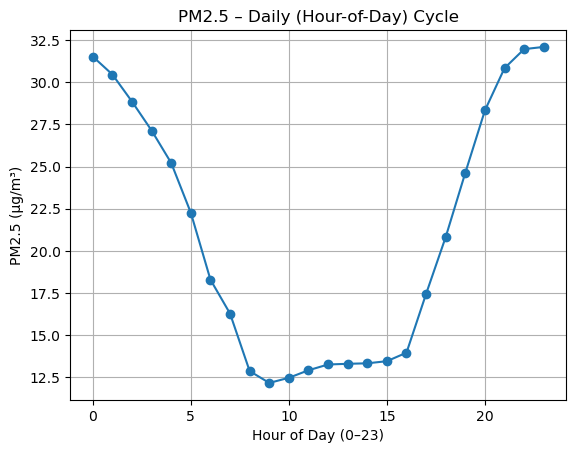

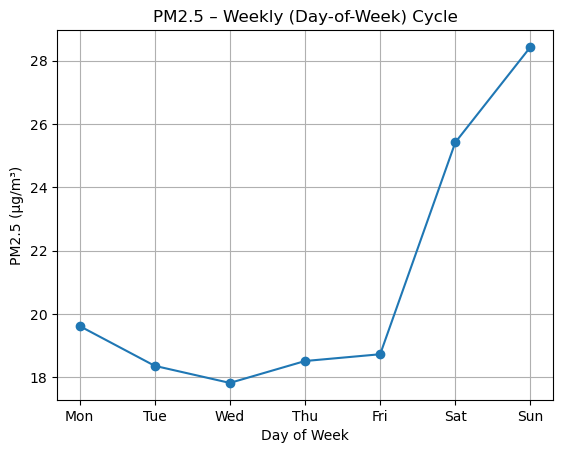

In [112]:
plot_daily_weekly_cycles(df, time_col=None, value_col="pm2.5_atm", tz="Asia/Bishkek", smooth_window=1)


In [113]:
def plot_pm25_heatmap(
    df: pd.DataFrame,
    time_col: str = None,       # e.g., "timestamp"; leave None if df.index is datetime
    value_col: str = "pm2.5_atm",   # change if your PM2.5 column is named differently
    tz: str = None,             # e.g., "Asia/Bishkek" to convert; None = leave as-is
    agg: str = "mean",          # "mean" or "median"
    resample_rule: str = None,  # e.g., "1H" to regularize irregular data; None = skip
    winsorize: tuple = None,    # e.g., (0.01, 0.99) to clip extremes; None = skip
    vmin: float = None,         # fix color scale min (None = auto)
    vmax: float = None,         # fix color scale max (None = auto)
    annotate: bool = False      # write values inside cells (small fonts)
):
    """
    Plots a heatmap of PM2.5 by hour-of-day (rows) vs day-of-week (columns).
    Mon=0 ... Sun=6 on the x-axis; Hours 0..23 on the y-axis.
    """
    # Drop "precip_mm" to avoid inconsistancies
    _df = df.drop(columns=['precip_mm']).copy()

    # Drop NAs --> 260 Weather_code
    _df = _df.dropna(subset=[value_col])

    # Build hour x weekday pivot: rows = hour(0..23), cols = weekday(0..6)
    hours = _df.index.hour
    weekdays = _df.index.dayofweek
    if agg == "median":
        mat = _df.groupby([hours, weekdays])[value_col].median().unstack(fill_value=np.nan)
    else:
        mat = _df.groupby([hours, weekdays])[value_col].mean().unstack(fill_value=np.nan)

    # Ensure full grid (24x7) even if some bins are empty
    mat = mat.reindex(index=range(24), columns=range(7))

    # Plot
    plt.figure()
    im = plt.imshow(mat.values, aspect="auto", origin="lower", vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im)
    cbar.set_label("PM2.5 (µg/m³)")

    # Ticks & labels
    day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    plt.xticks(ticks=range(7), labels=day_labels)
    plt.yticks(ticks=range(0, 24, 2))  # show every 2 hours for readability
    plt.xlabel("Day of Week")
    plt.ylabel("Hour of Day")
    plt.title(f"PM2.5 — Hour × Day Heatmap ({agg.capitalize()})")

    # Optional annotations
    if annotate:
        # Use small font; skip NaNs
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                val = mat.iat[i, j]
                if not np.isnan(val):
                    plt.text(j, i, f"{val:.0f}", ha="center", va="center", fontsize=6)

    plt.tight_layout()
    plt.show()

    # Return the matrix for further analysis if needed
    return mat



# Datetime in column "timestamp"; PM2.5 column "pm25"; resample hourly, winsorize 1–99%:
# heat = plot_pm25_heatmap(
#     last_df, time_col="timestamp", value_col="pm25",
#     tz="Asia/Bishkek", resample_rule="1H", winsorize=(0.01, 0.99)
# )


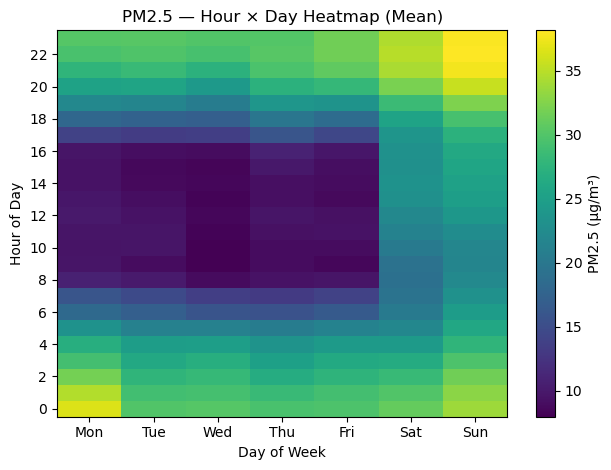

In [114]:
heat = plot_pm25_heatmap(df, value_col="pm2.5_atm", tz="Asia/Bishkek", agg="mean")

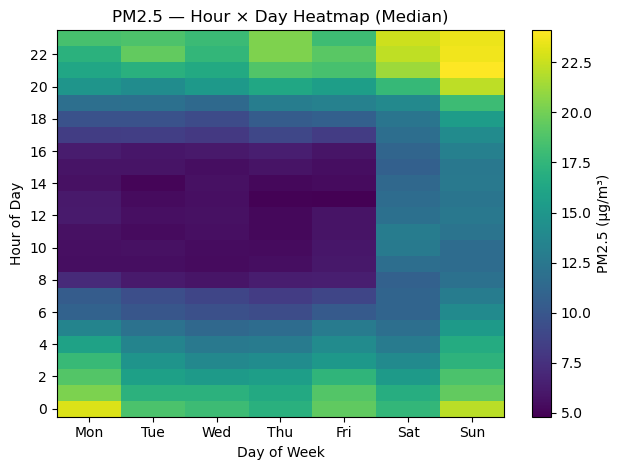

In [115]:
heat = plot_pm25_heatmap(df, value_col="pm2.5_atm", tz="Asia/Bishkek", agg="median")

In [116]:
def plot_decomposition(
    df,
    time_col=None,
    value_col="PM2_5",
    tz=None,
    resample_rule="1D",     # "1H" for hourly, "1D" for daily
    period=None,            # 24 (hourly→daily), 7 (daily→weekly), 168 (hourly→weekly)
    method="stl",           # "stl" (recommended) or "classical"
    classical_model="additive",
    robust=True,
    show_month_labels=True,
    fill_method="interpolate",   # "interpolate", "ffill", "bfill", or None
    min_len_factor=3             # need at least period*min_len_factor observations
):
    # Drop "precip_mm" to avoid inconsistancies
    _df = df.drop(columns=['precip_mm']).copy()

    # Drop NAs --> 260 Weather_code
    _df = _df.dropna(subset=[value_col])

    # Regularize time grid
    y = _df[value_col].resample(resample_rule).mean() if resample_rule else _df[value_col].copy()

    # Fill small gaps (prevents NaNs in STL)
    if fill_method == "interpolate":
        y = y.interpolate(method="time", limit_direction="both")
    elif fill_method == "ffill":
        y = y.ffill().bfill()
    elif fill_method == "bfill":
        y = y.bfill().ffill()
    # else: leave as-is

    y = y.dropna()

    # Choose default period
    if period is None:
        r = (resample_rule or "").upper()
        if r.endswith("H"):
            period = 24
        elif r.endswith("D"):
            period = 7
        else:
            raise ValueError("Please set period explicitly for this frequency.")

    # Sanity: enough data?
    if len(y) < period * min_len_factor:
        raise ValueError(
            f"Not enough data for period={period}. Need at least ~{period*min_len_factor} points, have {len(y)}."
        )

    # Decomposition
    if method.lower() == "stl":
        res = STL(y, period=period, robust=robust).fit()
        observed, trend, seasonal, resid = y, res.trend, res.seasonal, res.resid
        title = f"STL Decomposition of {value_col} (period={period})"
    else:
        dec = seasonal_decompose(y, model=classical_model, period=period, extrapolate_trend="freq")
        observed, trend, seasonal, resid = dec.observed, dec.trend, dec.seasonal, dec.resid
        title = f"Seasonal Decomposition of {value_col} ({classical_model}, period={period})"

    # Plot
    fig, axes = plt.subplots(4, 1, figsize=(13, 9), sharex=True)

    axes[0].plot(observed.index, observed.values, lw=0.8); axes[0].set_ylabel("Observed")
    axes[1].plot(trend.index, trend.values, color="tab:orange", lw=0.8); axes[1].set_ylabel("Trend")

    axes[2].plot(seasonal.index, seasonal.values, color="tab:green", lw=0.9); axes[2].set_ylabel("Seasonal")
    # Safe y-limits for seasonal
    lo, hi = np.nanmin(seasonal.values), np.nanmax(seasonal.values)
    if np.isfinite(lo) and np.isfinite(hi):
        if hi - lo < 1e-6:
            m = (hi + lo) / 2.0
            pad = 1e-3 if m == 0 else abs(m) * 1e-3
            axes[2].set_ylim(m - pad, m + pad)
        else:
            axes[2].set_ylim(lo, hi)

    axes[3].plot(resid.index, resid.values, color="gray", lw=0.6); axes[3].set_ylabel("Residual")

    # Year majors + Month minors (with names)
    ax = axes[3]
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    if show_month_labels:
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
        ax.tick_params(axis="x", which="minor", rotation=90, labelsize=8, pad=2)

    fig.suptitle(title, fontsize=14, y=0.97)
    fig.tight_layout()
    plt.show()

    return {"observed": observed, "trend": trend, "seasonal": seasonal, "resid": resid}


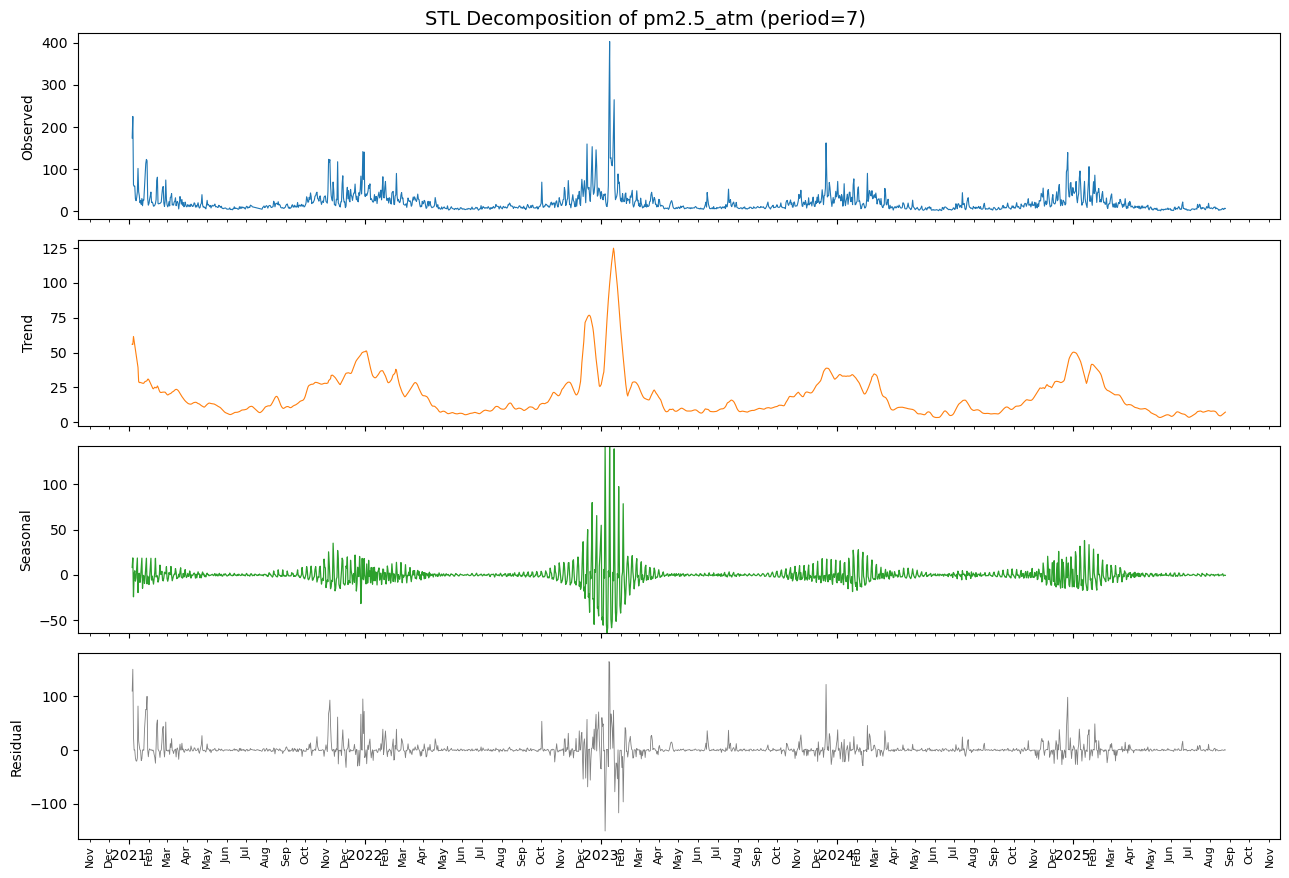

In [117]:
res = plot_decomposition(
    df, time_col="datetime_local", value_col="pm2.5_atm",
    tz="Asia/Bishkek", resample_rule="1D", period=7, method="stl"
)


## T-test for Weekdays vs Weekends and for Days vs Nights


In [118]:
df.info


<bound method DataFrame.info of                            pm2.5_atm  air_temp_c  dewpoint_c  \
datetime_local                                                 
2021-01-06 17:00:00+06:00       54.7       -11.7       -14.9   
2021-01-06 18:00:00+06:00       88.3       -10.8       -15.2   
2021-01-06 19:00:00+06:00      103.7       -12.2       -14.9   
2021-01-06 20:00:00+06:00      121.7       -12.0       -15.0   
2021-01-06 21:00:00+06:00      198.4       -11.8       -15.2   
...                              ...         ...         ...   
2025-08-25 19:00:00+06:00        3.7        28.9         6.3   
2025-08-25 20:00:00+06:00        3.4        26.9         7.3   
2025-08-25 21:00:00+06:00        4.3        24.9         7.9   
2025-08-25 22:00:00+06:00        6.0        23.1         8.4   
2025-08-25 23:00:00+06:00        6.6        22.0         7.8   

                           rel_humidity_pct  precip_mm  precip_occurrence  \
datetime_local                                            

In [119]:
def _ci_mean_diff_welch(x, y, alpha=0.05):
    # Mean diff CI using Welch SE and t critical
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = len(x), len(y)
    mx, my = np.mean(x), np.mean(y)
    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    se = np.sqrt(vx/nx + vy/ny)
    # Welch–Satterthwaite df
    df = (vx/nx + vy/ny)**2 / ((vx**2)/(nx**2*(nx-1)) + (vy**2)/(ny**2*(ny-1)))
    tcrit = stats.t.ppf(1 - alpha/2, df)
    diff = mx - my
    return diff, diff - tcrit*se, diff + tcrit*se, df, se

def _cohen_d_unpaired_welch(x, y):
    # Hedge’s g (small-sample correction) using pooled SD with Welch weights
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = len(x), len(y)
    sx2, sy2 = np.var(x, ddof=1), np.var(y, ddof=1)
    sp = np.sqrt(((nx-1)*sx2 + (ny-1)*sy2) / (nx + ny - 2))
    d = (np.mean(x) - np.mean(y)) / sp if sp > 0 else np.nan
    # small-sample correction
    J = 1 - 3/(4*(nx+ny)-9)
    return d * J

def prepare_df_for_tests(df, time_col=None, value_col="PM2_5", tz=None,
                         winsorize=None, dropna=True):
    _df = df.copy()
    # datetime index
    if time_col:
        _df[time_col] = pd.to_datetime(_df[time_col], errors="coerce", utc=tz is not None)
        _df = _df.set_index(time_col)
    if tz:
        _df = _df.tz_convert(tz)
    if not isinstance(_df.index, pd.DatetimeIndex):
        raise ValueError("Provide time_col or ensure DatetimeIndex.")
    # numeric
    _df[value_col] = pd.to_numeric(_df[value_col], errors="coerce")
    if dropna:
        _df = _df.dropna(subset=[value_col])
    # optional winsorize
    if winsorize is not None:
        lo_q, hi_q = winsorize
        lo, hi = _df[value_col].quantile(lo_q), _df[value_col].quantile(hi_q)
        _df[value_col] = _df[value_col].clip(lo, hi)
    return _df

def ttest_weekday_weekend(df, time_col=None, value_col="PM2_5", tz=None,
                          winsorize=None, log_transform=False, alpha=0.05, plot=True):
    d = prepare_df_for_tests(df, time_col, value_col, tz, winsorize)
    d["weekday"] = d.index.dayofweek <= 4  # Mon=0..Sun=6
    x = d.loc[d["weekday"], value_col].values
    y = d.loc[~d["weekday"], value_col].values
    if log_transform:
        x, y = np.log1p(x), np.log1p(y)
    # Welch t-test
    tstat, p = stats.ttest_ind(x, y, equal_var=False, nan_policy="omit")
    diff, lo, hi, df_welch, se = _ci_mean_diff_welch(x, y, alpha)
    d_cohen = _cohen_d_unpaired_welch(x, y)
    # Optional non-parametric check
    u_stat, p_u = stats.mannwhitneyu(x, y, alternative="two-sided")
    # Plot
    if plot:
        plt.figure()
        plt.boxplot([x, y], labels=["Weekday", "Weekend"], showmeans=True)
        plt.title("PM2.5: Weekday vs Weekend")
        plt.ylabel(f"{'log1p ' if log_transform else ''}{value_col}")
        plt.grid(True)
        plt.show()
    return {
        "n_weekday": len(x), "n_weekend": len(y),
        "mean_weekday": float(np.mean(x)), "mean_weekend": float(np.mean(y)),
        "mean_diff": float(diff), "ci95": (float(lo), float(hi)),
        "t_stat": float(tstat), "df": float(df_welch), "p_value": float(p),
        "se": float(se), "cohen_d": float(d_cohen),
        "mannwhitney_u": float(u_stat), "mannwhitney_p": float(p_u)
    }

def ttest_day_night(df, time_col=None, value_col="PM2_5", tz=None,
                    day_hours=range(7,22), winsorize=None,
                    log_transform=False, alpha=0.05, plot=True):
    d = prepare_df_for_tests(df, time_col, value_col, tz, winsorize)
    hours = d.index.hour
    is_day = hours.isin(day_hours)
    x = d.loc[is_day, value_col].values     # day
    y = d.loc[~is_day, value_col].values    # night
    if log_transform:
        x, y = np.log1p(x), np.log1p(y)
    tstat, p = stats.ttest_ind(x, y, equal_var=False, nan_policy="omit")
    diff, lo, hi, df_welch, se = _ci_mean_diff_welch(x, y, alpha)
    d_cohen = _cohen_d_unpaired_welch(x, y)
    u_stat, p_u = stats.mannwhitneyu(x, y, alternative="two-sided")
    if plot:
        plt.figure()
        plt.boxplot([x, y], labels=["Day", "Night"], showmeans=True)
        plt.title("PM2.5: Day vs Night")
        plt.ylabel(f"{'log1p ' if log_transform else ''}{value_col}")
        plt.grid(True)
        plt.show()
    return {
        "n_day": len(x), "n_night": len(y),
        "mean_day": float(np.mean(x)), "mean_night": float(np.mean(y)),
        "mean_diff": float(diff), "ci95": (float(lo), float(hi)),
        "t_stat": float(tstat), "df": float(df_welch), "p_value": float(p),
        "se": float(se), "cohen_d": float(d_cohen),
        "mannwhitney_u": float(u_stat), "mannwhitney_p": float(p_u)
    }


/var/folders/83/t702v3093vj_m1cq21gyvzgh0000gn/T/ipykernel_19559/2609073540.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x, y], labels=["Weekday", "Weekend"], showmeans=True)


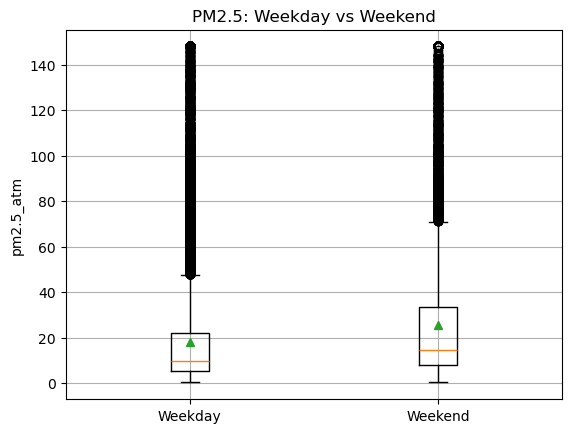

{'n_weekday': 28510,
 'n_weekend': 11422,
 'mean_weekday': 18.15581901087338,
 'mean_weekend': 25.535527928558924,
 'mean_diff': -7.379708917685544,
 'ci95': (-7.956472173885629, -6.8029456614854595),
 't_stat': -25.079497525741484,
 'df': 18068.642944147323,
 'p_value': 1.783630673312326e-136,
 'se': 0.2942526623633924,
 'cohen_d': -0.30032067892256487,
 'mannwhitney_u': 123545491.0,
 'mannwhitney_p': 0.0}

In [120]:
# Weekday vs Weekend (in local time), WITHOUT winsorization and log1p
res_wd = ttest_weekday_weekend(
    df, time_col=None, value_col="pm2.5_atm",
    tz="Asia/Bishkek", winsorize=(0.01, 0.99), log_transform=False
)
res_wd

/var/folders/83/t702v3093vj_m1cq21gyvzgh0000gn/T/ipykernel_19559/2609073540.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x, y], labels=["Weekday", "Weekend"], showmeans=True)


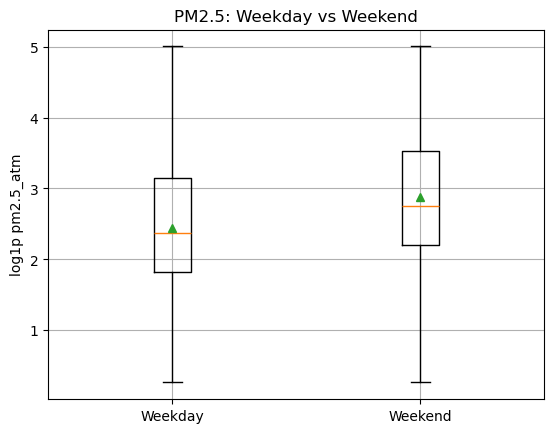

{'n_weekday': 28510,
 'n_weekend': 11422,
 'mean_weekday': 2.4464101302402366,
 'mean_weekend': 2.876209880506177,
 'mean_diff': -0.42979975026594053,
 'ci95': (-0.4495957358614111, -0.41000376467046995),
 't_stat': -42.555824133987656,
 'df': 24019.804416384086,
 'p_value': 0.0,
 'se': 0.0100996692935075,
 'cohen_d': -0.44408266446700906,
 'mannwhitney_u': 123545491.0,
 'mannwhitney_p': 0.0}

In [121]:
# Weekday vs Weekend (in local time), with light winsorization and log1p to reduce skew
res_wd = ttest_weekday_weekend(
    df, time_col=None, value_col="pm2.5_atm",
    tz="Asia/Bishkek", winsorize=(0.01, 0.99), log_transform=True
)
res_wd

/var/folders/83/t702v3093vj_m1cq21gyvzgh0000gn/T/ipykernel_19559/2609073540.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x, y], labels=["Day", "Night"], showmeans=True)


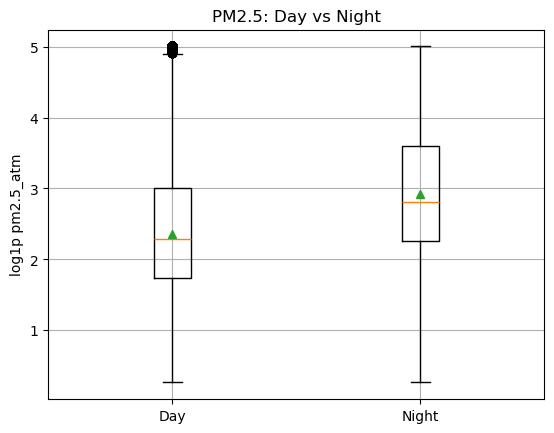

{'n_day': 24988,
 'n_night': 14944,
 'mean_day': 2.355903459980791,
 'mean_night': 2.9262517672839072,
 'mean_diff': -0.5703483073031164,
 'ci95': (-0.5889032603559456, -0.5517933542502871),
 't_stat': -60.248115943441405,
 'df': 34853.195299946,
 'p_value': 0.0,
 'se': 0.009466657975471585,
 'cohen_d': -0.6017847885549423,
 'mannwhitney_u': 124206221.5,
 'mannwhitney_p': 0.0}

In [122]:
# Day vs Night (07:00–21:59 vs 22:00–06:59)
res_dn = ttest_day_night(
    df, time_col=None, value_col="pm2.5_atm",
    tz="Asia/Bishkek", day_hours=range(7,22),
    winsorize=(0.01, 0.99), log_transform=True
)
res_dn

Great — let’s carefully interpret both sets of results in plain language.

---

## 1. Weekday vs Weekend

- **Sample sizes:** 28.5k weekday points vs 11.4k weekend points (big samples → high power).
- **Means (on log1p scale):**

  - Weekdays: **2.45**
  - Weekends: **2.88**

- **Mean difference:** −0.43 (weekdays lower).
- **95% CI:** \[−0.45, −0.41] → we’re 95% confident the true weekday–weekend difference in log1p scale is about **−0.42 ± 0.02**.
- **t-statistic & p-value:** t ≈ −42.6, p ≈ 0 → the probability of seeing this difference if weekday & weekend means were equal is effectively zero.
- **Effect size (Cohen’s d):** −0.44 → a **medium effect** (weekday mean is \~0.44 SD lower than weekend).
- **Mann–Whitney U:** also p ≈ 0 → confirms result is robust without normality assumptions.

### Back-translation

Since results are in log1p scale:

- Δ = −0.43 → `exp(−0.43) − 1 ≈ −0.35` → weekday PM2.5 is about **35% lower** than weekend PM2.5, on average.

👉 **Conclusion (Weekday vs Weekend):**
PM2.5 is **significantly lower on weekdays** than weekends, with a medium-sized effect. That suggests weekend activities (traffic changes, household heating, industry shutdown, or cultural patterns) lead to systematically higher pollution.

---

## 2. Day vs Night

- **Sample sizes:** 25k daytime vs 15k nighttime.
- **Means (log1p scale):**

  - Day: **2.36**
  - Night: **2.93**

- **Mean difference:** −0.57 (day lower).
- **95% CI:** \[−0.59, −0.55] → precise estimate.
- **t-statistic & p-value:** t ≈ −60.2, p ≈ 0 → difference is extremely significant.
- **Effect size (Cohen’s d):** −0.60 → a **moderately large effect** (night mean is \~0.6 SD higher than day).
- **Mann–Whitney U:** also p ≈ 0 → robust to distributional assumptions.

### Back-translation

- Δ = −0.57 → `exp(−0.57) − 1 ≈ −0.44` → daytime PM2.5 is about **44% lower** than nighttime PM2.5.

👉 **Conclusion (Day vs Night):**
PM2.5 is **substantially lower during the day** compared to the night, with a fairly large effect. This matches environmental physics: **nighttime inversion layers** trap pollutants near the ground, while daytime heating & mixing disperses them.

---

## Big picture insights

1. **Weekends are dirtier:** On average, weekend PM2.5 is \~35% higher than weekdays.
   → Suggests human activity differences, possibly higher domestic/transport/entertainment emissions on weekends.

2. **Nighttime is dirtier:** On average, night PM2.5 is \~44% higher than daytime.
   → Likely due to atmospheric dynamics (stable air, reduced mixing, inversion), not just emissions.

3. **Statistical certainty is very high:** Large n, narrow CIs, tiny p-values, and consistent parametric & non-parametric results.

4. **Practical effect sizes:** Cohen’s d \~0.44–0.60 = **medium to medium-large** → differences are not just statistically detectable, they’re **environmentally meaningful**.

---

✅ **Simple takeaway:**

> _“PM2.5 levels are on average \~35% higher on weekends than weekdays, and \~44% higher at night compared to daytime. These differences are statistically significant, robust across tests, and indicate both human activity patterns and atmospheric conditions strongly shape air quality.”_

---


In [123]:
df.describe()

,pm2.5_atm,air_temp_c,dewpoint_c,rel_humidity_pct,precip_mm,precip_occurrence,wind_dir_deg,wind_speed_kmh,slp_hpa,weather_code,wind_speed_ms
count,39932.000000,39932.000000,39932.000000,39932.000000,27792.000000,39932.000000,39932.000000,39932.000000,39932.000000,39690.000000,39932.000000
mean,20.992475,13.175974,2.796249,55.536136,0.073748,0.139612,193.714327,4.645620,1017.825759,3.600479,1.290450
std,30.078357,11.537801,6.697838,22.864752,0.325310,0.346589,100.100872,5.477461,10.364808,4.315979,1.521517
min,0.000000,-23.300000,-25.700000,9.000000,0.000000,0.000000,0.000000,0.000000,994.500000,1.000000,0.000000
25%,6.000000,4.000000,-1.800000,37.000000,0.000000,0.000000,133.000000,3.600000,1009.700000,2.000000,1.000000
50%,10.900000,13.800000,3.700000,53.000000,0.000000,0.000000,188.000000,3.700000,1017.000000,2.000000,1.027778
75%,26.100000,22.400000,8.100000,75.000000,0.000000,0.000000,280.000000,5.500000,1025.100000,3.000000,1.527778
max,489.000000,39.600000,18.700000,100.000000,10.300000,1.000000,359.000000,190.800000,1059.900000,25.000000,53.000000


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39932 entries, 2021-01-06 17:00:00+06:00 to 2025-08-25 23:00:00+06:00
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   pm2.5_atm                  39932 non-null  float64 
 1   air_temp_c                 39932 non-null  float64 
 2   dewpoint_c                 39932 non-null  float64 
 3   rel_humidity_pct           39932 non-null  float64 
 4   precip_mm                  27792 non-null  float64 
 5   precip_occurrence          39932 non-null  float64 
 6   wind_dir_deg               39932 non-null  float64 
 7   wind_speed_kmh             39932 non-null  float64 
 8   slp_hpa                    39932 non-null  float64 
 9   weather_code               39690 non-null  float64 
 10  wind_speed_ms              39932 non-null  float64 
 11  wx_group                   39932 non-null  category
 12  wx_drizzle_moderate        39932 non-null

In [125]:
# ---------- 1) Helper to add time features ----------
def _season_from_month(m: int) -> str:
    # Meteorological seasons: DJF, MAM, JJA, SON
    if m in (12, 1, 2):
        return "DJF"
    elif m in (3, 4, 5):
        return "MAM"
    elif m in (6, 7, 8):
        return "JJA"
    else:
        return "SON"

def add_time_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Expects X to have a DatetimeIndex (timezone-aware is fine).
    Returns a copy with time-derived columns added.
    """
    if not isinstance(X.index, pd.DatetimeIndex):
        raise ValueError("X must have a DatetimeIndex. Set df = df.set_index(<datetime_col>) first.")

    out = X.copy()

    # Basic discrete time features
    out["hour"] = out.index.hour
    out["day_of_week"] = out.index.dayofweek           # Mon=0..Sun=6
    out["month"] = out.index.month

    # Season (categorical)
    out["season"] = [ _season_from_month(m) for m in out["month"].values ]

    # Cyclical encodings (help linear/distance-based models)
    # hour: period=24, month: period=12
    out["hour_sin"]  = np.sin(2*np.pi*out["hour"] / 24.0)
    out["hour_cos"]  = np.cos(2*np.pi*out["hour"] / 24.0)
    out["month_sin"] = np.sin(2*np.pi*out["month"] / 12.0)
    out["month_cos"] = np.cos(2*np.pi*out["month"] / 12.0)

    return out

In [128]:
# ---------- 2) Build your dataset ----------
target = "pm2.5_atm"
X = df.drop(columns=[target])
y = df[target]

# Ensure DatetimeIndex exists (your df already has one per info())
# If not: df[<ts_col>] = pd.to_datetime(...); df = df.set_index(<ts_col>)

# Add time features up front (feature extraction doesn't leak label info)
X = add_time_features(X)

# Identify feature types
numeric_cols = X.select_dtypes(include=["float64"]).columns.tolist()
# Remove the target if present; ensure we keep added cyclical floats
# (already done since X = df.drop(target))

# Booleans stay as 0/1
bool_cols = X.select_dtypes(include=["bool"]).columns.tolist()

# Categorical columns:
# - your original categorical 'wx_group'
# - plus new discrete time features we want as categories (day_of_week, month, season)
categorical_cols = []
if "wx_group" in X.columns:
    categorical_cols.append("wx_group")
categorical_cols += ["day_of_week", "month", "season"]

# Important: these three are ints/obj right now; ensure dtypes suitable for OHE
X["day_of_week"] = X["day_of_week"].astype("int16")
X["month"] = X["month"].astype("int16")
X["season"] = X["season"].astype("category")

# NOTE: Keep the cyclical columns in numeric_cols
# They are float64 (hour_sin, hour_cos, month_sin, month_cos) and will be scaled.

# ---------- 3) Preprocessing pipelines ----------
from sklearn.preprocessing import RobustScaler  # optional alternative to StandardScaler

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())     # use RobustScaler() if you prefer outlier robustness
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Booleans: passthrough (already 0/1). If you wish, you can include them in numeric_transformer instead.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
        ("bool", "passthrough", bool_cols)
    ],
    remainder="drop"
)

# ---------- 4) Train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------- 5) Example model pipeline ----------
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())    # swap with Ridge, Lasso, SVR, etc.
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [129]:
# Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²:   {r2:.3f}")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

R²:   0.396
MAE:  12.93
RMSE: 22.57


In [145]:
# Get feature names after preprocessing
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

# Coefficients from linear regression
coefs = model.named_steps["regressor"].coef_

# Combine into DataFrame for inspection
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coefs})
coef_df = coef_df.sort_values(by="coefficient", key=abs, ascending=False)

coef_df.head(60)



,feature,coefficient
2,num__rel_humidity_pct,18.459999
1,num__dewpoint_c,-17.390774
0,num__air_temp_c,12.396367
65,bool__wx_hail,10.983474
21,cat__wx_group_hail,10.983474
76,bool__wx_snow_light,-10.725063
32,cat__wx_group_snow_light,-10.725063
61,bool__wx_freezing_drizzle_dense,9.943359
17,cat__wx_group_freezing_drizzle_dense,9.943359
20,cat__wx_group_freezing_rain_light,-8.801334


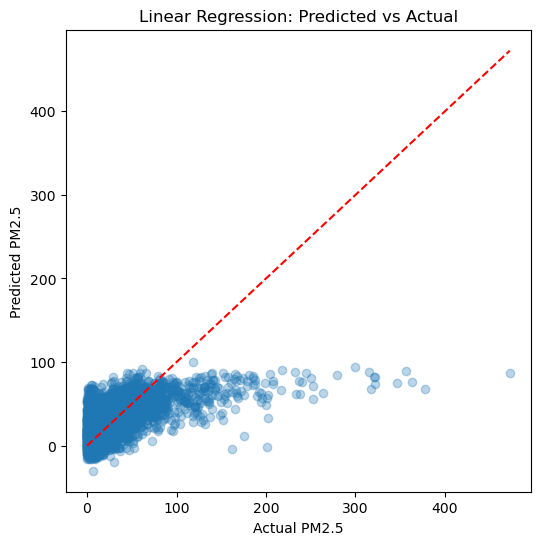

In [66]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Linear Regression: Predicted vs Actual")
plt.show()

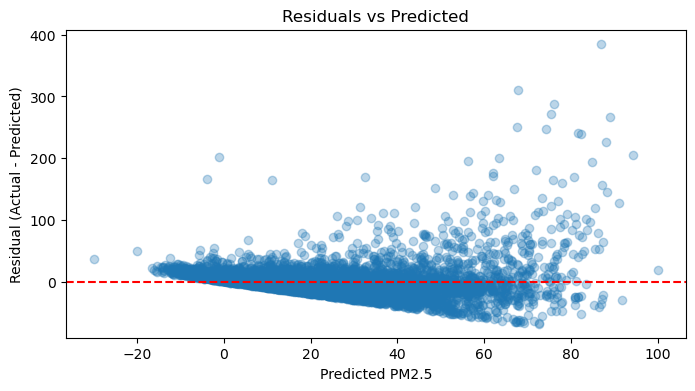

In [67]:
residuals = y_test - y_pred

plt.figure(figsize=(8,4))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted PM2.5")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.show()

In [68]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring="r2")
print("Cross-val R² scores:", scores)
print("Mean R²:", scores.mean())

Cross-val R² scores: [0.33120266 0.3454656  0.33527294 0.30021228 0.40736997]
Mean R²: 0.34390469097595
